In [5]:
# import packages
import os
import sys
from pathlib import Path
import numpy as np
import torch
import pickle
from tqdm import tqdm
import copy

# own modules
script_dir = os.getcwd()
src_dir = str(Path(script_dir).parents[2])
sys.path.append(src_dir)

from AE_settings import get_params

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

In [6]:
# AE settings

# setup directories
script_dir = os.getcwd()
src_dir = str(Path(script_dir).parents[1])
print(f'{src_dir = }')
sys.path.append(src_dir)

MRP_dir = str(Path(script_dir).parents[2])
dataset_dir = os.path.join(MRP_dir, 'data/bday_dataset/dataset')
save_model_dir = os.path.join(MRP_dir, 'src/neural_nets/saved_models')

print(f'dataset_dir: {dataset_dir}')

# setup pytorch devicef
device = torch.device("cpu")


src_dir = '/home/julius/git/MRP/src'
dataset_dir: /home/julius/git/MRP/data/bday_dataset/dataset


In [103]:
# get AE params
ae_name = 'WAE'
params = get_params(ae_name)

plot_params = params['plot_params']
print(f'{plot_params = }')

# get model name
hparams = {}
hparams.update(params['model_params'])
hparams.update(params['optimizer_params'])
model_name = f'{params["name"]},{hparams=}'

image_dir = f'images/{model_name}/'
example_dir = f'images/{model_name}/examples'

if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

if not os.path.isdir(example_dir):
    os.mkdir(example_dir)

# get perf dict
perf_dict_file = f'performance_dicts/{model_name}_perf_dict.pkl'
with open(perf_dict_file, 'rb') as f:
    perf_dict = pickle.load(f)

# get species list
print('loading species list...')
species_file = os.path.join(dataset_dir, 'species_list.pkl')
with open(species_file, 'rb') as f:
    spec_list = pickle.load(f)

print('extracting inputs and outputs...')
x = perf_dict['actual']
x_pred = perf_dict['predictions']

print(f'x.shape: {x.shape}')
print(f'x_pred.shape: {x_pred.shape}')

plot_params = {'dim_names': ['index', 'Wavelength'], 'xlog': False, 'ylog': False, 'label': 'Wavelength [nm]', 'title': 'Wavelength'}
loading species list...
extracting inputs and outputs...
x.shape: (2500, 1330)
x_pred.shape: (2500, 1330)


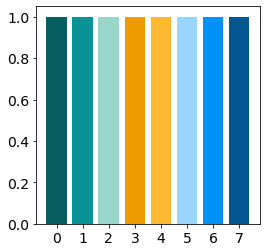

In [79]:
colors = [
'#065e60', '#0a9396', '#99d5c9', '#ee9b00', '#ffb833', '#99d6ff', '#0093f5', '#00568f'
]

# Set general font size
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

f, ax = plt.subplots(1, 1, figsize=(4, 4))

indices = np.arange(len(colors))

for i, c in enumerate(colors):
    ax.bar(indices[i], 1, color=c)

ax.set_xticks(indices)
plt.show()

In [80]:
def plot_example(x, x_pred, plot_params, index=None):
    if not index:
        index = np.random.randint(0, x.shape[-1])

    f, ax = plt.subplots(figsize=(6, 5))

    ax.plot(x[:, index], color=colors[2], label='actual', linewidth=2)
    ax.plot(x_pred[:, index], color=colors[0], linestyle=':', label='reconstructed', linewidth=2)

    ax.set_xlabel(plot_params['dim_names'][0])
    ax.set_ylabel(plot_params['label'])

    ax.legend()

    if plot_params['xlog']:
        ax.set_xscale('log')
    if plot_params['ylog']:
        ax.set_yscale('log')

    ax.set_title(f'{ae_name} example {index}')

    plt.tight_layout()
    plt.savefig(
        f'{image_dir}examples/{ae_name}_example_{index}.png',
        dpi=300)
    plt.show()


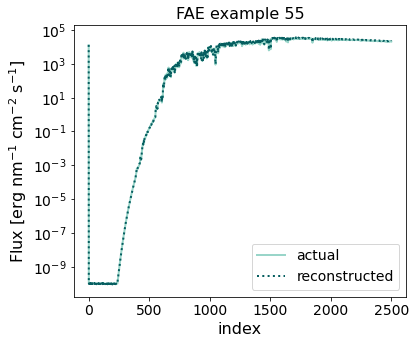

In [81]:
plot_params = params['plot_params']
plot_example(x, x_pred, plot_params)

In [91]:
def pred_plot(x, x_pred, plot_params, percentiles, nbins=150):

    x = x.flatten()
    x_pred = x_pred.flatten()

    # xmin, xmax = plot_params['xrange']
    xmin, xmax = np.min(x), np.max(x)

    f, ax = plt.subplots(figsize=(5.5,5.5))

    if percentiles:
        # bin data to calculate quantiles
        if plot_params['ylog']:
            bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins+1)
        else:
            bins = np.linspace(xmin, xmax, nbins+1)

        centers = 0.5 * (bins[:-1] + bins[1:])

        q1 = []
        q2 = []
        q3 = []

        for i in tqdm(range(len(centers)), desc='calculating quantiles'):
            inner_edge = bins[i]
            outer_edge = bins[i+1]

            msk = (x > inner_edge) & (x < outer_edge)
            x_pred_msk = x_pred[msk]

            if len(x_pred_msk) > 0:
                q1.append(np.quantile(x_pred_msk, 0.05))
                q2.append(np.quantile(x_pred_msk, 0.50))
                q3.append(np.quantile(x_pred_msk, 0.95))
            else:
                q1.append(np.nan)
                q2.append(np.nan)
                q3.append(np.nan)


        ax.text(
            x=0.02,
            y=0.95,
            s=f'bins = {len(centers)}',
            transform=ax.transAxes,
            alpha=0.3
        )

        ax.fill_between(
            centers,
            q1,
            q3,
            # alpha=0.3,
            color=colors[-3],
            label='5 - 95 percentile'
        )

        ax.plot(
            centers,
            q2,
            color=colors[-2],
            label='median'
        )
    else:
        threshold = 500000
        if len(x) > threshold:
            x = x[:threshold]
        if len(x_pred) > threshold:
            x_pred = x_pred[:threshold]

        ax.scatter(
            x,
            x_pred,
            s=1,
            # marker='+',
            c=colors[4],
            alpha=1,
            label='reconstructions'
        )

    def y(x):
        return x

    x_line = [xmin, xmax]

    ax.plot(
        x_line,
        y(x_line),
        linestyle='--',
        c=colors[0],
        alpha=0.5,
        label='perfect reconstruction'
    )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)

    if plot_params['ylog']:
        ax.set_xscale('log')
        ax.set_yscale('log')

    ax.legend(loc='upper right')

    ax.set_xlabel(f'Actual {plot_params["label"]}')
    ax.set_ylabel(f'Reconstructed {plot_params["label"]}')
    ax.set_title(f"{ae_name} reconstruction")

    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(
        f'{image_dir}{plot_params["title"]}.png' if not percentiles else f'{image_dir}{plot_params["title"]}_percentiles.png',
        dpi=300)
    plt.show()

In [92]:
def R_squared(predicted_values, actual_values, log_space = False):

    if log_space:
        predicted_values    = np.log10(predicted_values)
        actual_values       = np.log10(actual_values)

    actual_mean = actual_values.mean()
    ss_res = np.sum((actual_values - predicted_values) ** 2)
    ss_tot = np.sum((actual_values - actual_mean) ** 2)

    return (1.0 - ss_res / ss_tot)


r_squared = R_squared(x_pred.flatten(), x.flatten(), log_space=True)
print(f"{r_squared = }")

r_squared = 0.9999639677281381


In [93]:
def pred_plot_hist(x, x_pred, plot_params, nbins=150, logscale=True, fax=None, norm_axis=None):
    x       = x.flatten()
    x_pred  = x_pred.flatten()

    xmin, xmax = np.min(x), np.max(x)

    if fax:
        f, ax = fax
    else:
        f, ax = plt.subplots(figsize=(5.5,5.5))

    if plot_params['ylog']:
        ybins = np.logspace(np.log10(xmin), np.log10(xmax), nbins+1)
    else:
        ybins = np.linspace(xmin, xmax, nbins+1)
    xbins = ybins

    H_np, xedges, yedges = np.histogram2d(x, x_pred, bins=(xbins, ybins))

    if norm_axis is not None:
        if norm_axis == 0:
            div_array = np.tile(np.sum(H_np, axis=0)[None, ...], (nbins, 1))
        elif norm_axis == 1:
            div_array = np.tile(np.sum(H_np, axis=1)[..., None], (1, nbins))

        # print(f'{norm_axis = }')
        # print(f'{div_array.shape = }')
        # print(f'{div_array = }')
        H_np = H_np / div_array

    # get minimum value
    H_np_nans = np.where(H_np == 0, np.nan, H_np)
    H_min = np.nanmin(H_np_nans)
    H_max = np.nanmax(H_np_nans)

    imH = ax.pcolor(
        xedges,
        yedges,
        H_np.T,
        # cmap='gnuplot2',
        cmap='inferno',
        norm=SymLogNorm(linthresh=H_min) if logscale else None,
    )

    if plot_params['ylog']:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)

    if not fax:
        ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    cbar = f.colorbar(imH, cax=cax, orientation='vertical')
    cbar.set_label(
        'counts' if not norm_axis else 'fraction'
                   )

    def y(x):
        return x

    x_line = [xmin, xmax]

    ax.plot(
        x_line,
        y(x_line),
        linestyle='--',
        c='white',
        alpha=0.75,
        label='perfect reconstruction'
    )

    ax.legend(loc='lower right', frameon=False, labelcolor='white')

    ax.set_xlabel(f'Actual {plot_params["label"]}')
    ax.set_ylabel(f'Reconstructed {plot_params["label"]}')
    ax.set_title(
        f"{ae_name} reconstruction" if norm_axis is None else f"{ae_name} reconstruction\nnormalized over axis {norm_axis}"
    )

    ax.text(
        x=0.02,
        y=0.95,
        color='white',
        s=f'bins = {nbins} x {nbins}',
        transform=ax.transAxes,
        alpha=0.5
    )

    r_squared = R_squared(x, x_pred, log_space=logscale)
    print(f"{r_squared = }")
    ax.text(
        x=0.02,
        y=0.89,
        color='white',
        s=f'$R^2 = $ {r_squared:.4f}',
        transform=ax.transAxes,
        alpha=1.0
    )

    if not fax:
        # plt.tight_layout(h_pad=0, w_pad=0.1)
        plt.savefig(
            f'{image_dir}{plot_params["title"]}.png' if norm_axis is None else f'{image_dir}{plot_params["title"]}_norm_axes_{norm_axis}.png',
            dpi=300,
        bbox_inches='tight')
        plt.show()

    f, ax = plt.subplots(figsize=(5.5,5.5))
    num_per_bin = np.sum(H_np, axis=1)
    ax.plot(xedges[:-1], num_per_bin)
    # ax.set_xlim(xmin, xmax)
    # ax.set_ylim(0, np.max(num_per_bin))
    ax.set_xscale('log')
    ax.set_ylabel('counts')
    plt.show()

r_squared = 0.9999967232954476


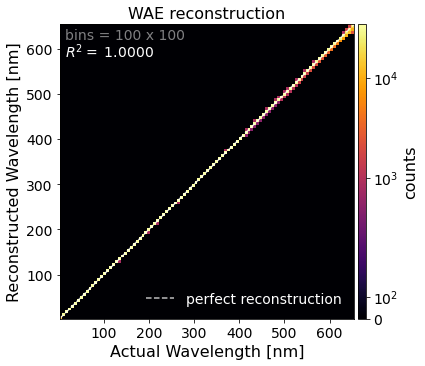

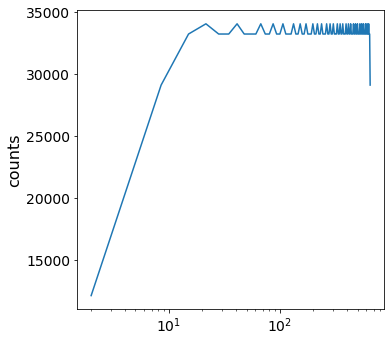

In [104]:
plot_params = params['plot_params']

# pred_plot_hist(x, x_pred, nbins=100, plot_params=plot_params,logscale=False)
pred_plot_hist(x, x_pred, nbins=100, plot_params=plot_params,logscale=True, norm_axis=None)
# pred_plot_hist(x, x_pred, nbins=100, plot_params=plot_params,logscale=True, norm_axis=1)

In [236]:
# taken from:
# https://gist.github.com/artoby/0bcf790cfebed5805fbbb6a9853fe5d5
def symlogspace(col, n_cuts, dtype='float64'):
    """
    Splits a data range into log-like bins but with 0 and negative values
    taken into account. Log cuts start from the closest value to zero.

    Parameters
    ----------
    col: df column or array
    n_cuts: int
            Number of cuts to perform
    dtype: dtype of the outputs
    """
    min_val = col.min()
    max_val = col.max()

    # compute negative and positive range
    min_pos = col[col > 0].min() if not np.isnan(col[col > 0].min()) else 0
    # max_neg = col[col < 0].max() if not np.isnan(col[col < 0].max()) else 0

    # neg_range = [-min_val, -max_neg] if min_val < max_neg else None
    neg_range = [max_val, max(min_val, min_pos)] if max_val > min_pos else None
    pos_range = [max(min_val, min_pos), max_val] if max_val > min_pos else None

    # If min value is 0 create a bin for it
    # zero_cut = [min_val] if max_neg <= min_val < min_pos else []
    zero_cut = [0]

    n_cuts = n_cuts - len(zero_cut)

    neg_range_size = (neg_range[0] - neg_range[1]) if neg_range is not None else 0
    pos_range_size = (pos_range[1] - pos_range[0]) if pos_range is not None else 0
    range_size = neg_range_size + pos_range_size

    n_pos_cuts = max(2, int(round(n_cuts * (pos_range_size / range_size)))) if range_size > 0 and pos_range_size > 0 else 0
    n_neg_cuts = n_pos_cuts
    # # Ensure each range has at least 2 edges if it's not empty
    # n_neg_cuts = max(2, n_cuts - n_pos_cuts) if pos_range_size > 0 else 0
    # # In case n_pos_cuts + n_neg_cuts > n_cuts this is needed
    # n_pos_cuts = max(2, n_cuts - n_neg_cuts) if pos_range_size > 0 else 0

    neg_cuts = []
    if n_neg_cuts > 0:
        neg_cuts = list(-np.geomspace(neg_range[0], neg_range[1], n_neg_cuts, dtype=dtype))

    pos_cuts = []
    if n_pos_cuts > 0:
        pos_cuts = list(np.geomspace(pos_range[0], pos_range[1], n_pos_cuts, dtype=dtype))

    result = neg_cuts + zero_cut + pos_cuts
    # Add 0.1% to the edges to include min and max
    result[0] = min(result[0] * 1.1, result[0] * 0.9)
    result[-1] = result[-1] * 1.1

    # calculate centers
    pos_centers = np.exp(0.5 * (np.log(pos_cuts[:-1]) + np.log(pos_cuts[1:])))
    neg_centers = - pos_centers[::-1]
    zero_centers = [-0.5 * pos_cuts[0], 0.5 * pos_cuts[0]]

    centers = np.concatenate([neg_centers, zero_centers, pos_centers])

    return result, centers

In [237]:
# from: https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None,
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


def error_hist(x, x_pred, plot_params, nbins=150, plot_quantiles=False, log=True, log_error=True):
    f, ax = plt.subplots(figsize=(7, 5.5))

    x = x.flatten()
    x_pred = x_pred.flatten()

    if log_error:
        x_e = np.log10(x_pred) - np.log10(x)
    else:
        x_e = np.abs(x_pred - x)

    # extent = plot_params['hist_extent']
    extent = np.max(np.abs(x_e))
    datamin = -extent
    datamax = extent

    if log_error:
        mybins = np.linspace(datamin, datamax, nbins+1)
        centers = 0.5 * (mybins[:-1] + mybins[1:])
    else:
        # mybins, centers = symlogspace(x_e, nbins+1)
        mybins = np.logspace(np.log10(x_e.min()), np.log10(x_e.max()), nbins+1)
        centers = np.exp(0.5 * (np.log(mybins[:-1]) + np.log(mybins[1:])))

    myhist, _ = np.histogram(x_e, bins=mybins)

    ax.bar(
        # centers,
        mybins[:-1],
        # log_hist,
        myhist,
        width=1.0 * (datamax - datamin) / nbins if log_error else np.diff(np.abs(mybins)),
        align='edge',
        color=colors[-5]
    )

    if log:
        ax.set_yscale('log')

    if not log_error:
        # ax.set_xscale('symlog', linthresh=np.min(np.abs(centers)))
        ax.set_xscale('log')
        # pass
    ymin, ymax = ax.get_ylim()


    if plot_quantiles:
        qax = ax

        quantiles = weighted_quantile(
        centers,
        [0.05, 0.5, 0.95],
        myhist
    )

        qax.axvline(
            quantiles[1],
            label=f'median: {quantiles[1]:.2f}',
            color=colors[-1],
            # linewidth=1,
            # linestyle='dotted'
        )

        qax.axvline(
            quantiles[0],
            linestyle='--',
            label=f'5 perc.: {quantiles[0]:.2f}',
            color=colors[-1],
            # linewidth=1,
        )

        qax.axvline(
            quantiles[2],
            linestyle='--',
            label=f'95 perc.: {quantiles[2]:.2f}',
            color=colors[-1],
            # linewidth=1,
        )

        qax.legend(loc='upper right',)

    ax.text(
        x=0.02,
        y=0.95,
        s=f'bins = {len(centers)}',
        transform=ax.transAxes,
        alpha=0.3
    )

    # ax.set_xlim(datamin, datamax)
    ax.set_ylim(ymin, ymax)

    if log_error:
        ax.set_xlabel('$\log_{10}$(reconstruction) - $\log_{10}$(actual)')
    else:
        ax.set_xlabel('log10(reconstruction - actual)')

    ax.set_ylabel('counts')
    ax.set_title(f'{ae_name} reconstruction error')

    plt.tight_layout()

    save_name = ''
    if log:
        save_name += 'logscale_'
    if log_error:
        save_name += 'log_'

    plt.savefig(
        f'{image_dir}{plot_params["title"]}_{save_name}error.png',
        dpi=300)
    plt.show()

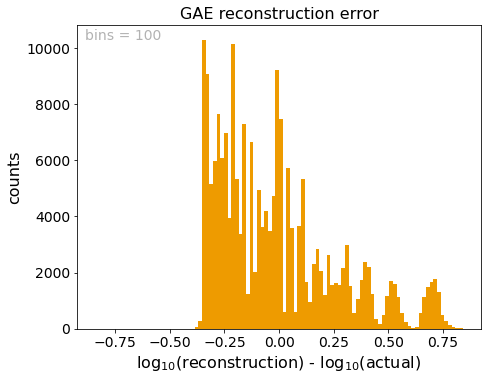

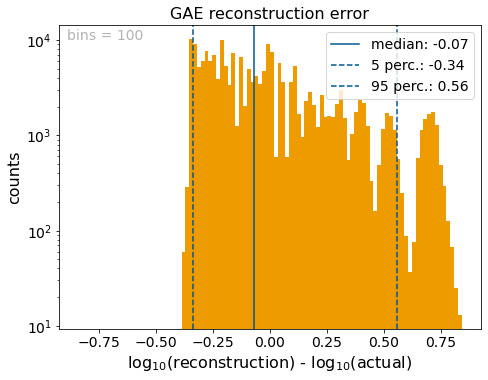

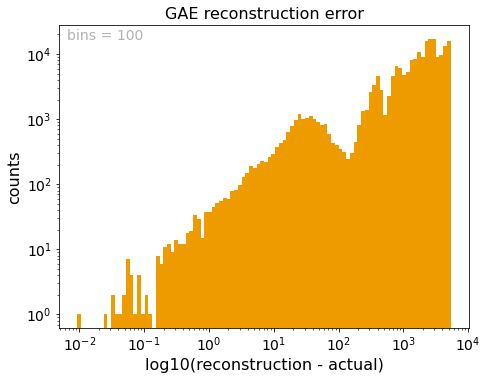

In [238]:
plot_params = params['plot_params']

error_hist(
    x,
    x_pred,
    plot_params,
    nbins=100,
    plot_quantiles=False,
    log=False,
    log_error=True
)

error_hist(
    x,
    x_pred,
    plot_params,
    nbins=100,
    plot_quantiles=True,
    log=True,
    log_error=True
)

error_hist(
    x,
    x_pred,
    plot_params,
    nbins=100,
    plot_quantiles=False,
    log=True,
    log_error=False
)

In [239]:
def dist_plot_2d(x, x_pred, plot_params, nbins=100, fig_spec_r=None):

    if not fig_spec_r:
        fig = plt.figure(figsize=(20, 5))
        spec = gridspec.GridSpec(1, 4, figure=fig)
        row = 0
    else:
        fig, spec, row = fig_spec_r

    # calculate points
    x_coords = np.zeros(x.shape[1] * x.shape[0])
    y_coords = np.zeros(x.shape[1] * x.shape[0])

    x_pred_coords = np.zeros(x.shape[1] * x.shape[0])
    y_pred_coords = np.zeros(x.shape[1] * x.shape[0])

    # x_error_coords = np.zeros(x.shape[1] * x.shape[0])
    # y_error_coords = np.zeros(x.shape[1] * x.shape[0])

    x_log_error_coords = np.zeros(x.shape[1] * x.shape[0])
    y_log_error_coords = np.zeros(x.shape[1] * x.shape[0])

    for i_0 in tqdm(range(x.shape[0])):
        for i_1 in range(x.shape[1]):
            x_coords[i_0 * x.shape[1] + i_1] = i_0 + 1
            y_coords[i_0 * x.shape[1] + i_1] = x[i_0, i_1]

            x_pred_coords[i_0 * x.shape[1] + i_1] = i_0 + 1
            y_pred_coords[i_0 * x.shape[1] + i_1] = x_pred[i_0, i_1]

            # x_error_coords[i_0 * x.shape[1] + i_1] = i_0 + 1
            # y_error_coords[i_0 * x.shape[1] + i_1] = x_pred[i_0, i_1] - x[i_0, i_1]

            x_log_error_coords[i_0 * x.shape[1] + i_1] = i_0 + 1
            y_log_error_coords[i_0 * x.shape[1] + i_1] = np.log10(x_pred[i_0, i_1]) - np.log10(x[i_0, i_1])

    def plot_single_hist(x_c, y_c, ax, error=False, error_log=False, xlog=False):
        xmin, xmax = np.min(x_coords), np.max(x_coords)

        if error:
            if error_log:
                y_close_zero = np.abs(y_c).min()
                ybins, ycenters = symlogspace(y_c, nbins+1)
            else:
                ybins = np.linspace(y_c.min(), y_c.max(), nbins+1)

        else:
            ymin, ymax = np.min(y_coords), np.max(y_coords)
            ybins = np.logspace(np.log10(ymin), np.log10(ymax), nbins+1)

        if xlog:
            x_close_zero = np.abs(x_c).min()
            xbins, xcenters = symlogspace(x_c, nbins+1)
        else:
            xbins = np.linspace(xmin - 0.5, xmax + 0.5, x.shape[0] + 1)

        H_np, xedges, yedges = np.histogram2d(x_c, y_c, bins=(xbins, ybins))

        # get minimum value
        H_np_nans = np.where(H_np == 0, np.nan, H_np)
        H_min = np.nanmin(H_np_nans)

        imH = ax.pcolor(
            xedges,
            yedges,
            H_np.T,
            # cmap='gnuplot2',
            cmap='inferno',
            norm=SymLogNorm(linthresh=H_min),
        )

        if error:
            if error_log:
                ax.set_yscale('symlog', linthresh=y_close_zero)
            else:
                ax.set_yscale('linear')
        else:
            ax.set_yscale('log')

        if xlog:
            ax.set_xscale('symlog', linthresh=x_close_zero)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.05)
        cbar = fig.colorbar(imH, cax=cax, orientation='vertical')
        cbar.set_label('counts')

        return (H_np, xedges, yedges)

    # actual

    xlog = plot_params['xlog']

    # f, ax = plt.subplots(figsize=(5,5))
    ax1 = fig.add_subplot(spec[row, 0])
    _ =  plot_single_hist(x_coords, y_coords, ax1, xlog=xlog)

    ax1.set_xlabel(plot_params['dim_names'][0])
    ax1.set_ylabel(f"{plot_params['label']}")
    ax1.set_title(
        f"Actual {plot_params['title']} distribution"
        , y=1.04)

    # predicted
    # f, ax = plt.subplots(figsize=(5,5))
    ax2 = fig.add_subplot(spec[row, 1])
    _ =  plot_single_hist(x_pred_coords, y_pred_coords, ax2, xlog=xlog)

    ax2.set_xlabel(plot_params['dim_names'][0])
    ax2.set_ylabel(f'{plot_params["label"]}')
    ax2.set_title(
        f"Reconstructed {plot_params['title']} distribution",
        y=1.04)

    # log error
    # f, ax = plt.subplots(figsize=(5,5))
    ax3 = fig.add_subplot(spec[row, 2])
    _ =  plot_single_hist(x_log_error_coords, y_log_error_coords, ax3, error=True, xlog=xlog)

    ax3.set_xlabel(plot_params['dim_names'][0])
    ax3.set_ylabel(f'log({plot_params["label"]})')
    ax3.set_title(
        f"log(Reconstructed) - log(Actual) {plot_params['title']} distribution",
        y=1.04)

    ax4 = fig.add_subplot(spec[row, 3])
    pred_plot_hist(x, x_pred, plot_params=plot_params, nbins=150, logscale=True, fax=(fig, ax4))

    ax4.set_title(f"{ae_name} reconstruction", y=1.04)

    plt.tight_layout()

    # ax4 = fig.add_subplot(spec[row, 3])
    # _ =  plot_single_hist(x_log_error_coords, y_log_error_coords, ax4, error=True, error_log=True)
    #
    # ax4.set_xlabel('Height layer')
    # ax4.set_ylabel(f'log({plot_params["title"]})')
    # ax4.set_title(
    #     f"log(Predicted) - log(Actual) {plot_params['title']} distribution",
    #     y=1.04)

    plt.tight_layout()

    plt.tight_layout()
    plt.savefig(
        f'{image_dir}{plot_params["title"]}_distributions.png',
        dpi=300)
    plt.show()

In [240]:
# plot_params = params['plot_params']
#
# dist_plot_2d(
#     x,
#     x_pred,
#     plot_params,
#     nbins=150
# )